# Crisis annotation and annotation optimization

Is it possible to easily annotate stock market crisis, the period previous to the crisis and the estable periods?

This is the goal in the current notebook. For this aim, I will work with the historical data of the opening stock prices (daily based) of the index S&P 500 since 1950.

The hypothesis is that one can recognize market bubbles and strong crisis in the time series after time series decomposition by extracting the general trend and the seasonality. These values are known as the residuals that keep changes that do not follow a temporary pattern or the general trend. These are the events that we want to recognize and label. However, in order to be successful, in the residuals obtention, it is really important the right election of the frequency used for seasonal decomposition (moving average). In this project the focus is to annotate events that could take from one two 5 years.

The idea is that one can extract the information of significant growths and drops on stock prices out of the distribution of these residual values. The main efford will be on the optimization of:
1. The threshold on the right tail of the residuals distribution to efficiently define pre-crisis periods
2. The threshold on the left tail of the residuals distribution to efficiently define crisis periods

I want to mention that one can play around with these thresholds depending on the type of stock bubble/crisis to annotate. In this case, it will be focused on detecting the major ones since those have high impact not just on the markets but also in the civil population.

Thus, the parameters to optimize are:
* Logarithmic transformation of the data before decomposition
* Frequency considered for the moving average during time series decomposition
* Standard deviations (threshold) to consider in the left tail of the residuals' distribution (estable vs crisis)
* Standard deviations (threshold) to consider in the right tail of the residuals' distribution (estable vs pre-crisis)

The optimization will be based on three type of metrics:
* Percentage of days labeled as crisis during the month after the oficial crisis
* Percentage of days labeled as pre-crisis during the previous month to the oficial crisis
* Percentage of days labeled as stable during periods that are consider as stable

The seasonal decomposition will be two-sided (moving average will be performed from events in the past and in the future) in order to optimize labeling. Additionally, the period between each "pre-crisis" and "crisis". Additionally, events labeled as "standard" or estable that are close to others labeled as "pre-crisis" and "crisis" will be corrected to addopt those labels. 

In this notebook the historical opening stock market prices are decomposed for annotation purpose. However, for the training of the classification model for annotation prediction, the decomposition will not be done two-sided but one-sided considering only the moving average of the past historical data as it may happen in the real life.

In [2]:
import sys
import datetime
import pandas as pd
from pandas.core import datetools
import numpy as np
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.grid_search import ParameterGrid
sys.path.append("../..")
from src.plotter import plot_time_series
from src.helpers import time_series_decomposition, time_series_annotation_optimization, annotation_evaluation, \
                        check_label, complete_crisis_annotation
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%reload_ext autoreload
%autoreload 2

### Extract stock market historical data from Yahoo Finance

In [2]:
# Download S&P 500 Index historical data
#yf.pdr_override()
#data = pdr.get_data_yahoo("^GSPC", start="1951-01-01", end="2018-07-18")
#data_.to_csv('../../data/S_and_P_500_50_18.csv', index=False, encoding="utf-8")

In [3]:
data = pd.read_csv('../../data/S_and_P_500_50_18.csv')
data['Date'] = data['Date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
data_ = data.reset_index()

In [4]:
# split between training and test data for posterior classification and label only training
data_train = data_[data_['Date'].dt.year < 2006]
data_test = data_[data_['Date'].dt.year >= 2006]

## Run annotation optimization Grid Search

In [31]:
# Parameters for the annotation optimization
col_time_series = 'Open'
col_label = 'label'
col_date = 'Date'
metrics = True
two_sided = True
plot = False

# Parameters for the grid search
param_grid = {"frequency": [1*365, 2*365, 5*365], 
              "left_tail_multiplier": [0, 0.2, -0.2, -0.8, -1], 
              "right_tail_multiplier": [0, 0.2, -0.2, -0.8, -1], 
              "log_scale": [True, False]}
grid = ParameterGrid(param_grid)

In [32]:
results_grid_search = []
for params in grid:
    # from selected articles calculate normalized frequencies of words
    metrics, data_labeled = time_series_annotation_optimization(data_train, 
                                                    col_time_series, col_date, col_label,
                                                    params['frequency'], 
                                                    params['left_tail_multiplier'], 
                                                    params['right_tail_multiplier'], 
                                                    params['log_scale'], two_sided, plot, metrics)
    metrics["frequency"] = params["frequency"]
    metrics["left_tail_multiplier"] = params["left_tail_multiplier"]
    metrics["right_tail_multiplier"] = params["right_tail_multiplier"]
    metrics["log_scale"] = params['log_scale']
    
    results_grid_search.append(metrics)
results_gs = pd.DataFrame.from_records(results_grid_search)

interval: [0.9895368651894842, 1.0103940068071755]
interval: [0.9895368651894842, 1.0083082926454063]
interval: [0.9895368651894842, 1.0124797209689447]
interval: [0.9895368651894842, 1.018736863454252]
interval: [0.9895368651894842, 1.0208225776160211]
interval: [0.9490880606981726, 1.0473829217534067]
interval: [0.9490880606981726, 1.0375534356478833]
interval: [0.9490880606981726, 1.0572124078589302]
interval: [0.9490880606981726, 1.0867008661755004]
interval: [0.9490880606981726, 1.096530352281024]
interval: [0.9916225793512534, 1.0103940068071755]
interval: [0.9916225793512534, 1.0083082926454063]
interval: [0.9916225793512534, 1.0124797209689447]
interval: [0.9916225793512534, 1.018736863454252]
interval: [0.9916225793512534, 1.0208225776160211]
interval: [0.958917546803696, 1.0473829217534067]
interval: [0.958917546803696, 1.0375534356478833]
interval: [0.958917546803696, 1.0572124078589302]
interval: [0.958917546803696, 1.0867008661755004]
interval: [0.958917546803696, 1.096530

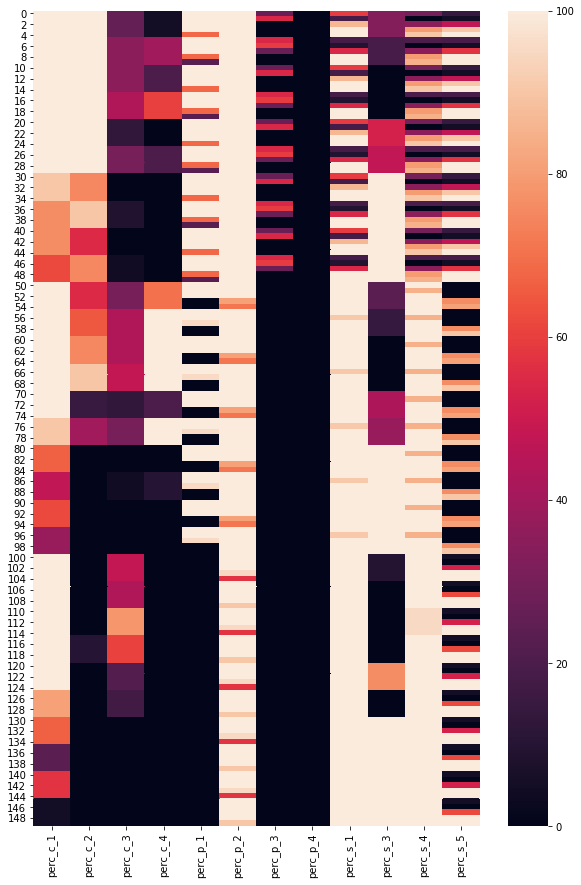

In [33]:
_=plt.figure(figsize=(10,15))
_=sns.heatmap(results_gs.loc[:,('perc_c_1', 'perc_c_2', 'perc_c_3','perc_c_4', 'perc_p_1', 'perc_p_2',
                                'perc_p_3', 'perc_p_4', 'perc_s_1', 'perc_s_3','perc_s_4', 'perc_s_5')])

In [34]:
results_gs.to_csv('../../data/results_gs_crisis_annotation.csv',index=False,encoding='utf-8')

In [35]:
results_gs = pd.read_csv('../../data/results_gs_crisis_annotation.csv')

In [36]:
results_gs['sum'] = results_gs.sum(axis=1)
results_gs['std'] = results_gs.std(axis=1)

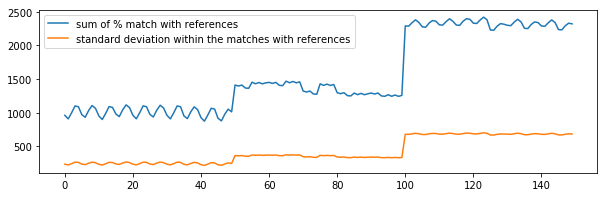

In [37]:
_=plt.figure(figsize=(10, 3))
_=plt.plot(results_gs['sum'], label='sum of % match with references')
_=plt.plot(results_gs['std'], label='standard deviation within the matches with references')
_=plt.legend()

In [41]:
results_gs.loc[71]

frequency                    730
left_tail_multiplier        -0.2
log_scale                   True
perc_c_1                     100
perc_c_2                      15
perc_c_3                 13.0435
perc_c_4                      20
perc_p_1                     100
perc_p_2                     100
perc_p_3                       0
perc_p_4                       0
perc_s_1                     100
perc_s_3                 42.8571
perc_s_4                      85
perc_s_5                       0
right_tail_multiplier        0.2
sum                       1306.9
std                       343.59
Name: 71, dtype: object

In the graph we see clearly three types of values, the first is for those paramaters that have 1 year as fequency, the second is 2 years and the last is 5 years. The performance for combination of parameters with frequency 5 is higher but the standard deviation as well. This means that those parameters are overfitting the prediction of specific crisis and pre-crisis and other periods are completly wrong labeled. 

Thus, we choose frequency 2 years as a good compromise. The election of the rest of parameters will be done based on the highest sum of matches and lowest standard deviation and also after several iterations of the classifier optimization.

## Annotate Time Series with optimal parameters

In [8]:
# Desired parameters for time series decomposition (Crisis Annotation)
frequency = 365*2
left_tail_multiplier = -0.2
right_tail_multiplier = 0.2
log_scale = True
two_sided = True
metrics = False
plot = True
annotation_colors = ['green', 'orange', 'red']

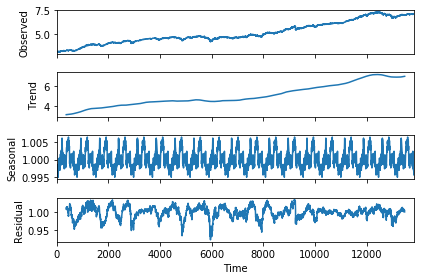

interval: [0.9806404858975003, 1.0127459268282746]


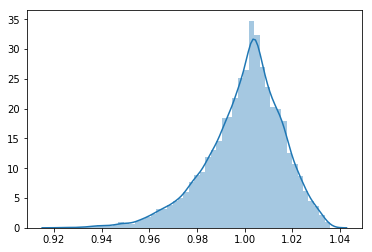

In [9]:
data_labeled = time_series_annotation_optimization(data_train, col_time_series, col_date, col_label, frequency,
                                                   left_tail_multiplier, right_tail_multiplier, log_scale, 
                                                   two_sided, plot, metrics)

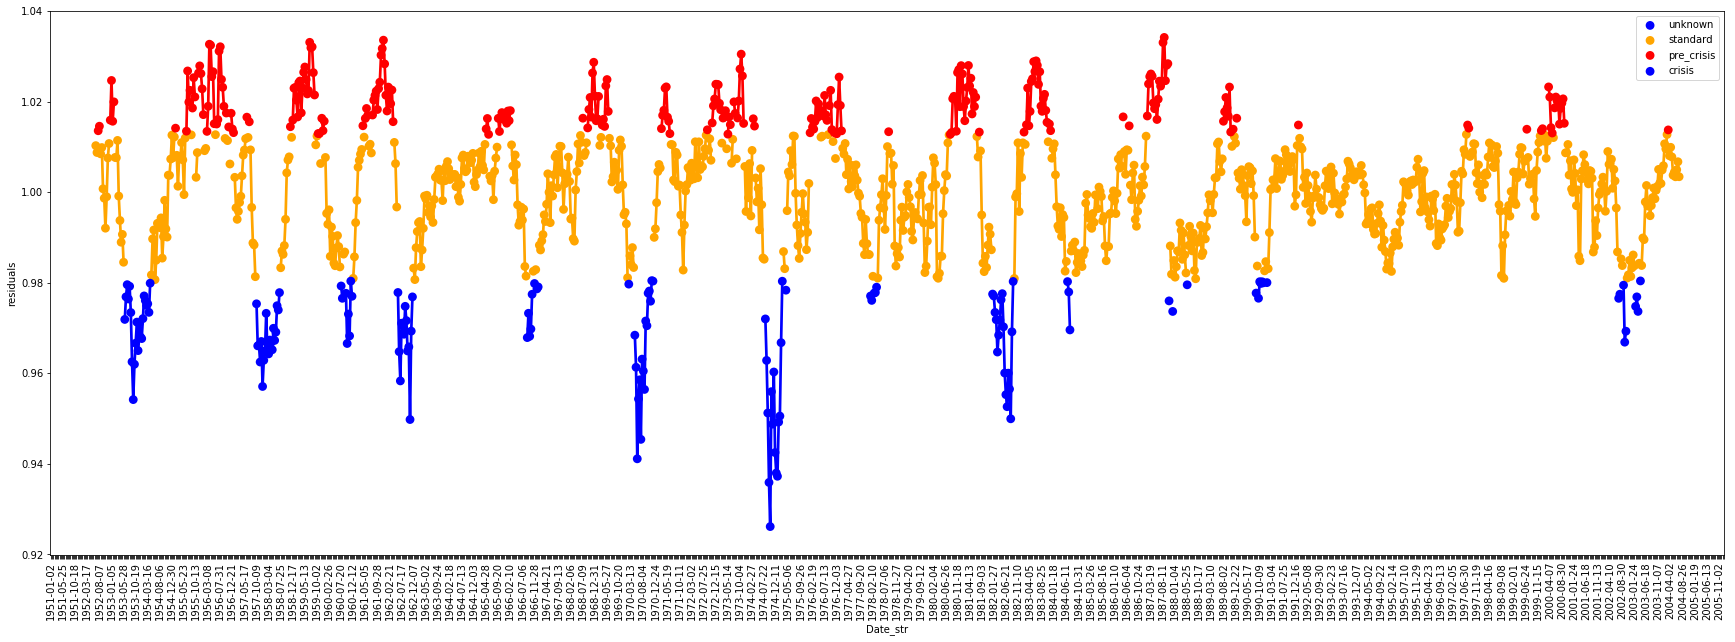

In [10]:
plot_time_series(data_labeled, 'Date_str', 'residuals', col_label, ['blue', 'orange', 'red'])

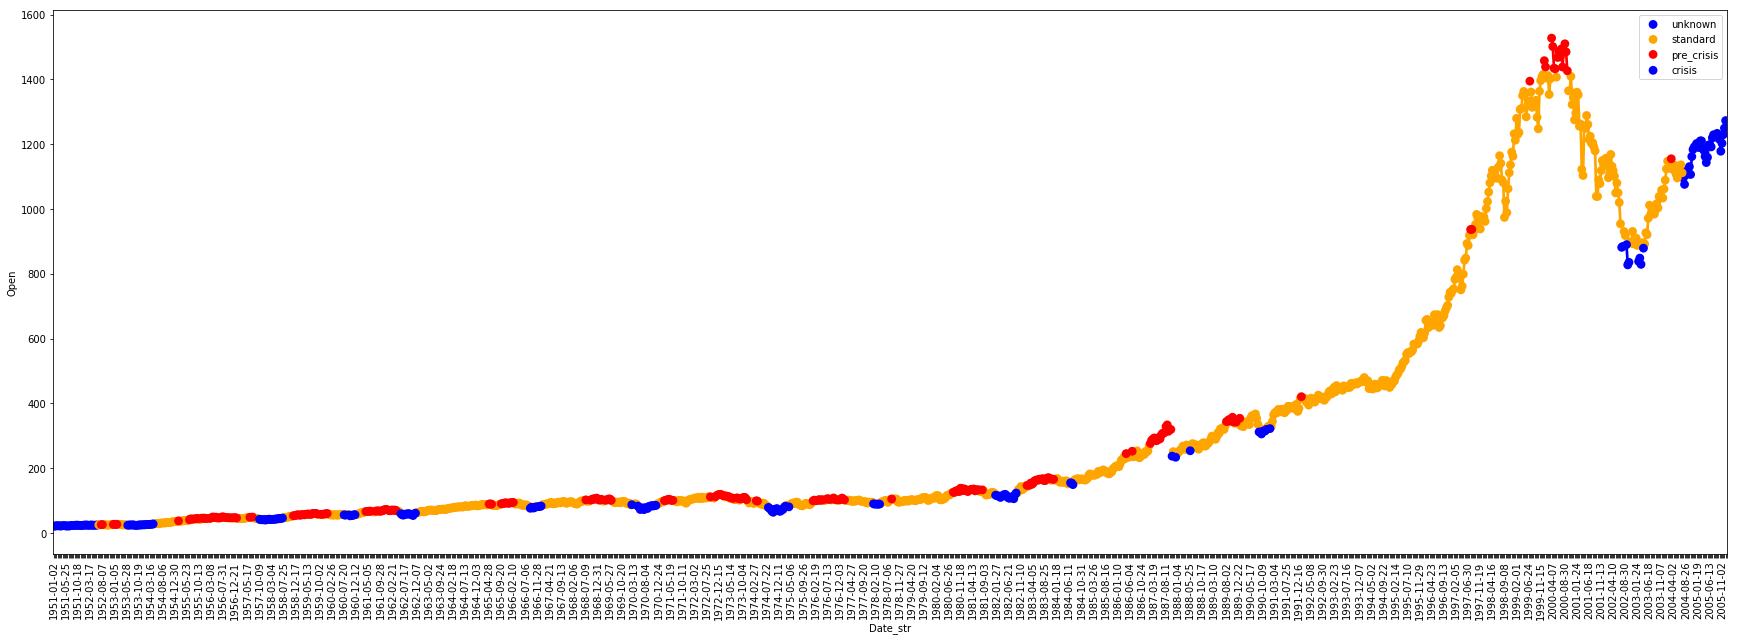

In [11]:
plot_time_series(data_labeled, 'Date_str', 'Open', col_label, ['blue', 'orange', 'red'])

In [12]:
data_labeled.dropna().to_csv('../../data/training_labeling.csv', index=False, encoding='utf-8')

### Correct annotation according to wikipedia reported stock crisis

This correction, as mentioned above, is focused on give the same label to those "standard" events that are close to those labeled as "crisis" or "pre-crisis".

In [13]:
# Annotation parameters
thrs_btw_crisis_i = 365/2
thrs_btw_crisis_g = 365 / 4
thrs_btw_precrisis_i = 365*2
thrs_btw_precrisis_g = 365 #/ 2

annotation_column = col_label
annotation_colors = ['blue', 'orange', 'red']

In [14]:
# Order data temporally and select relevant columns
data_labeled_ = data_labeled.sort_values(by=col_date).dropna()
data_labeled_ = data_labeled_.loc[:, (col_date, 'Date_str', col_time_series, 'residuals', col_label)]

# Correct annotation according to given rules
labeled_correct = complete_crisis_annotation(data_labeled_, annotation_column, thrs_btw_crisis_i, 
                                             thrs_btw_crisis_g, thrs_btw_precrisis_i, thrs_btw_precrisis_g)

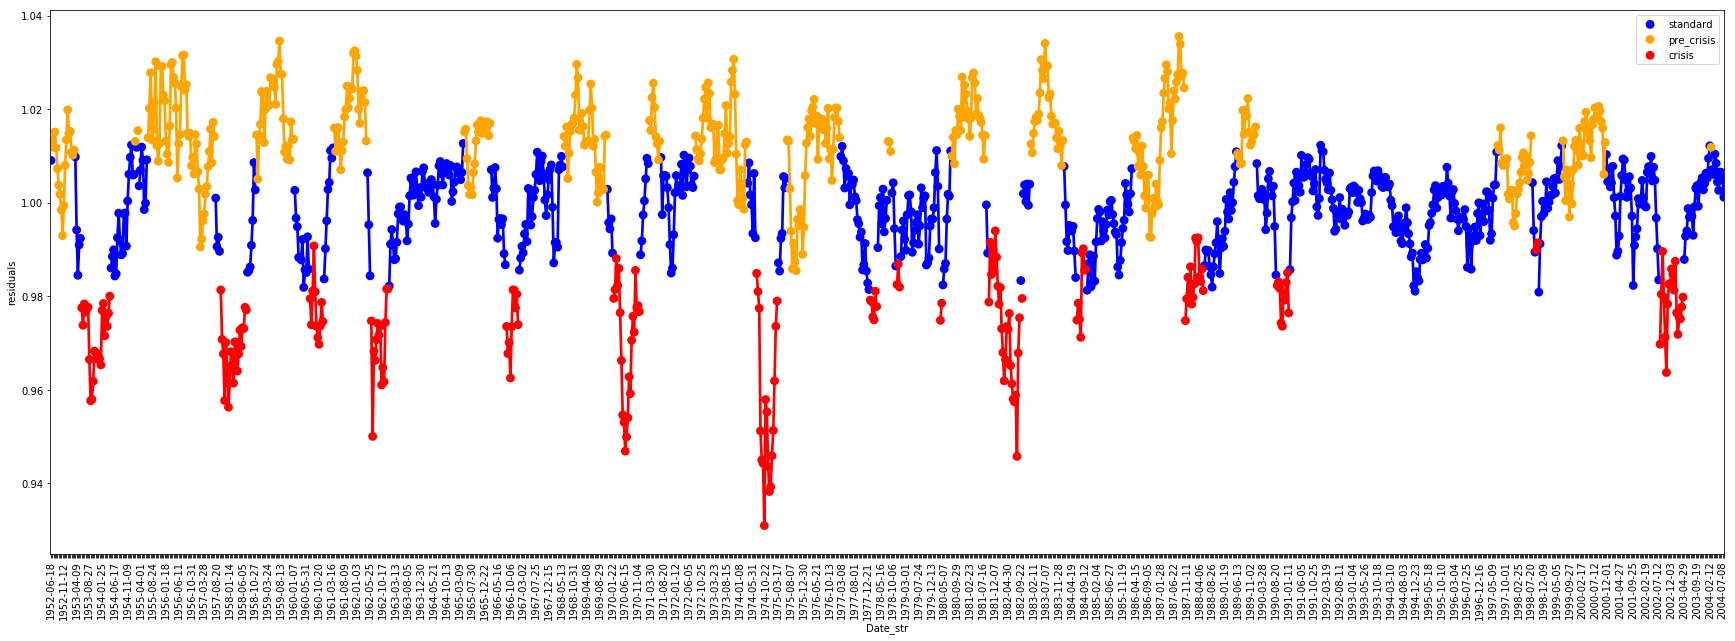

In [15]:
plot_time_series(labeled_correct, 'Date_str', 'residuals', col_label, annotation_colors)

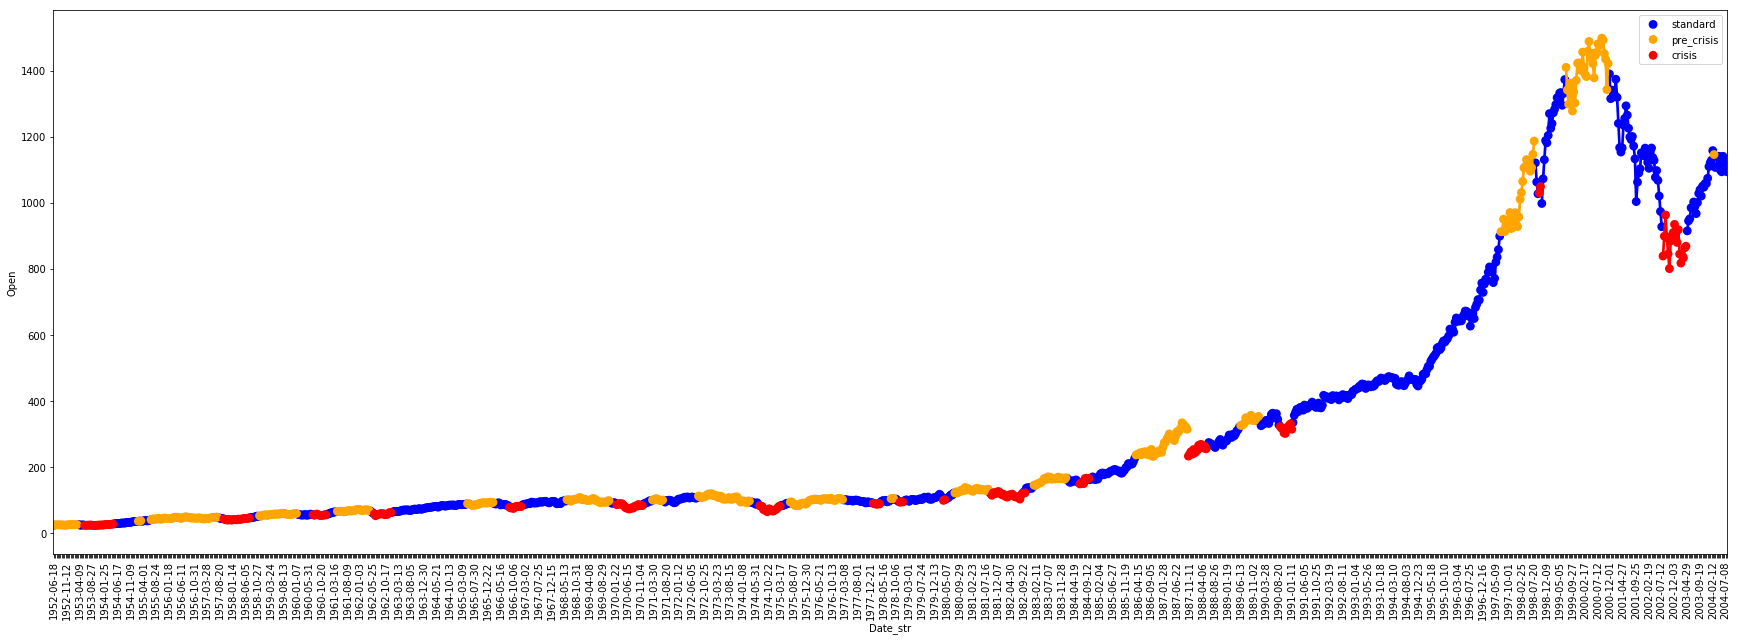

In [16]:
plot_time_series(labeled_correct, 'Date_str', col_time_series, col_label, annotation_colors)

In [17]:
labeled_correct.to_csv('../../data/training_correct_labeling.csv', index=False, encoding='utf-8')